# Explicación local

**Descripción**\
Se va a dar explicación a los movimientos incorrectos de un paciente

**Entrada**
* ``raw.csv``:  contiene información detallada sobre cada grabación.


**1. Importar librerías**

In [10]:
import pandas as pd
import functions as fn
import joblib
import shap
import numpy as np
# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**2. Input data**

In [11]:
# Dataframe de los datos en bruto
names = ['SubjectID','GestureLabel','GestureName','RepetitionNumber','CorrectLabel','JointName','3D_X','3D_Y','3D_Z']
df_raw = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object, names=names, skiprows=1136726, nrows=21225)
# coge un solo pacinte realizando un solo gesto

In [12]:
gesture = 'EFL' # vendrá dado por la fase1

**3. Caracterización de movimientos**

In [13]:
# Cálculo de ángulos según gesto
df_calculations = fn.apply_angles_II(df_raw, gesture)
#  Cálculos estadísticos para agrupar por repeticion 
df_stats = fn.calculos_estadisticos(df_calculations)

columnas = ['standardDeviation', 'Maximum', 'Minimum', 'Mean', 'Range',
                'Variance', 'CoV', 'Skewness', 'Kurtosis']
nuevas_columnas = pd.concat([fn.formatear_columnas(df_stats[col], col)
                                for col in columnas], axis=1)
df_stats = pd.concat([df_stats, nuevas_columnas], axis=1)
df_stats = df_stats.drop(columnas, axis=1)

# elimnar correctlabel
df_stats = df_stats.drop(['CorrectLabel'], axis=1)  


**4. Fase 2: Clasificación de la ejecución del movimiento**

In [14]:
correct_mapping = {
            1: 'correcta',
            2: 'incorrecta'
        }

In [15]:
modelo_gesto_path = f'../Resultados/modelo_{gesture}.sav'
best_pipeline, expected_columns = joblib.load(modelo_gesto_path)
df_stats = df_stats.reindex(columns=expected_columns)


Para enterder **waterfall**, la gráfica parte de un va,ro base que es el promdeio de todas las salidas, en este caso 1.53. Despues se ve como las disitntas variables lelvan al modelos a una predicción u a otr (hay que leerlo como de abajo a arriba)

Repetición 1: correcta


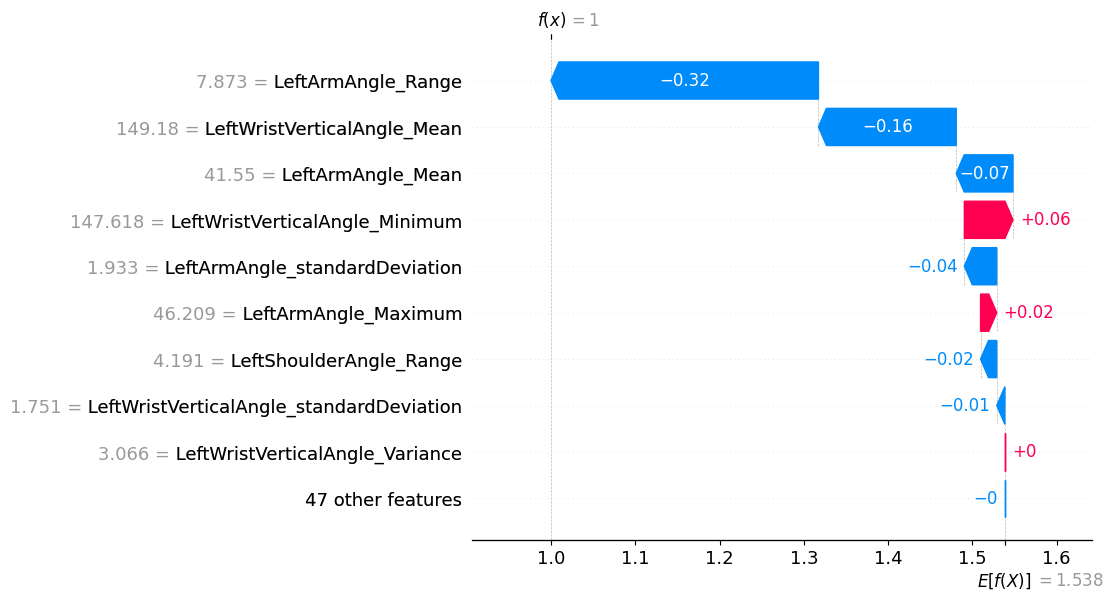

¡Buen trabajo con ese LeftArmAngle_Range
Repetición 2: correcta


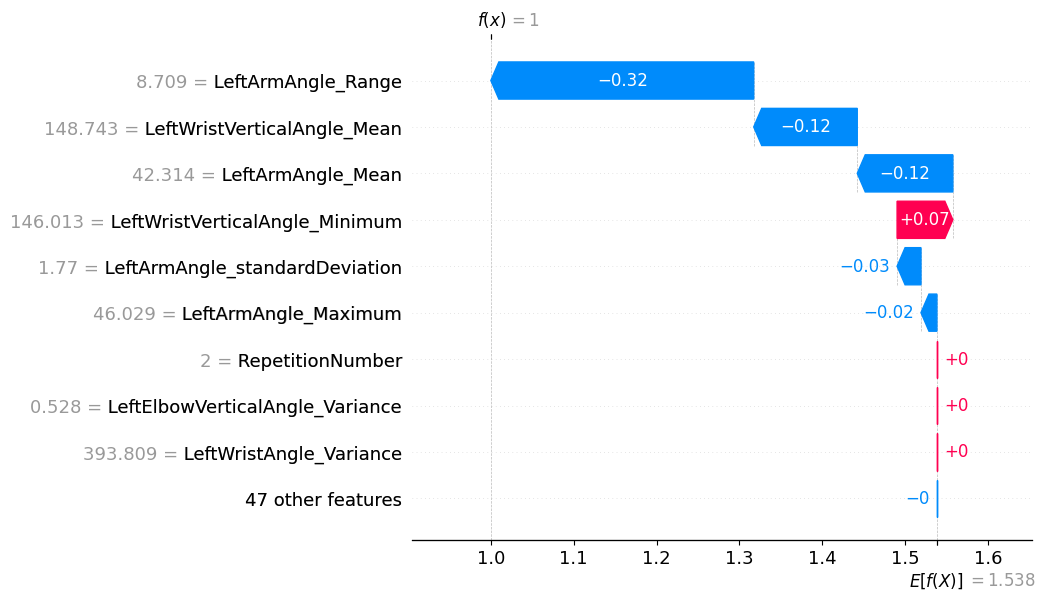

¡Buen trabajo con ese LeftArmAngle_Range
Repetición 3: incorrecta


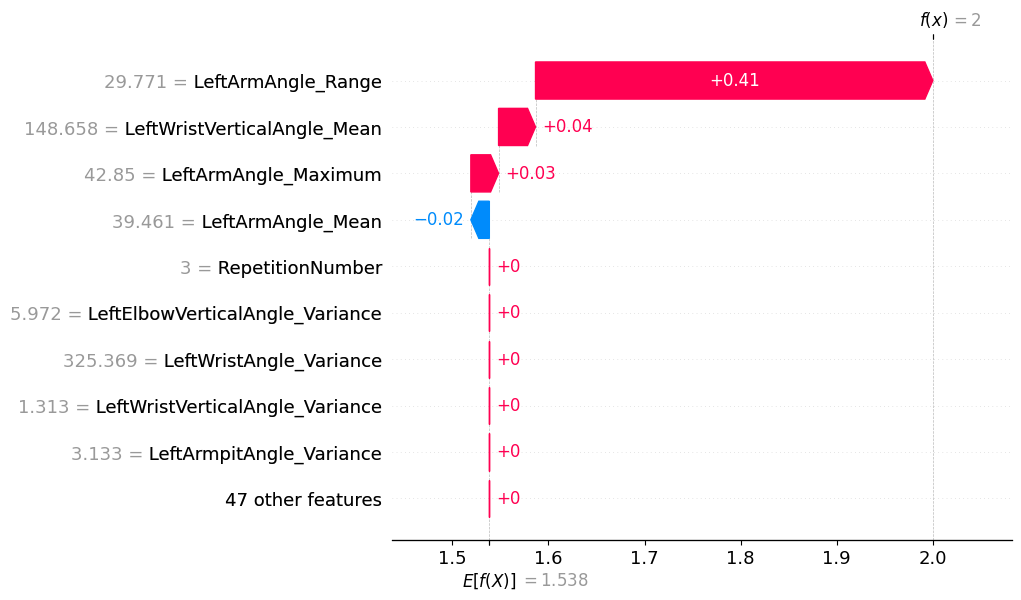

Mejora LeftArmAngle_Range
Repetición 4: correcta


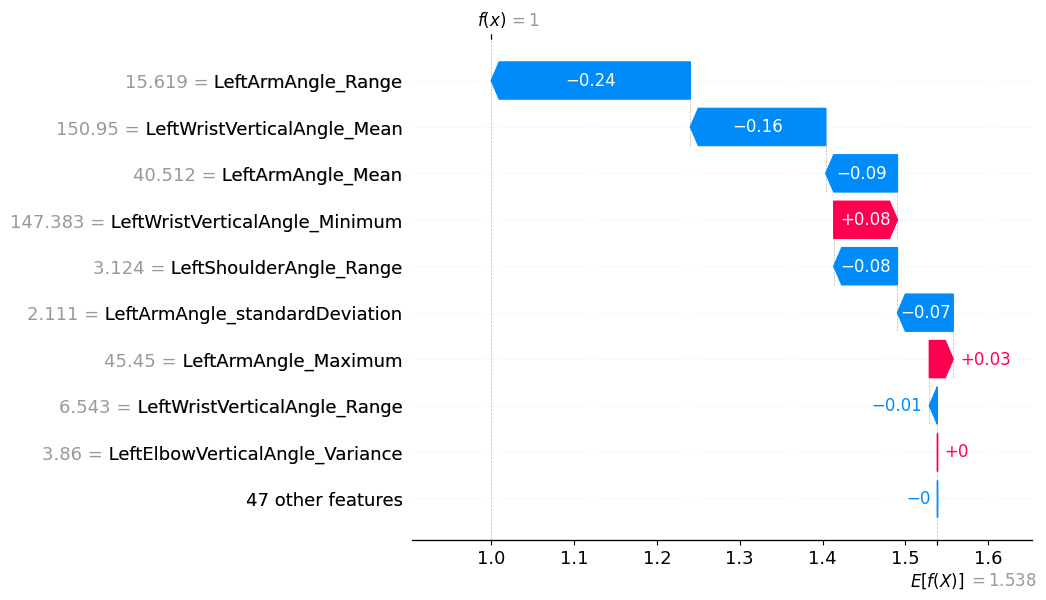

¡Buen trabajo con ese LeftArmAngle_Range
Repetición 5: correcta


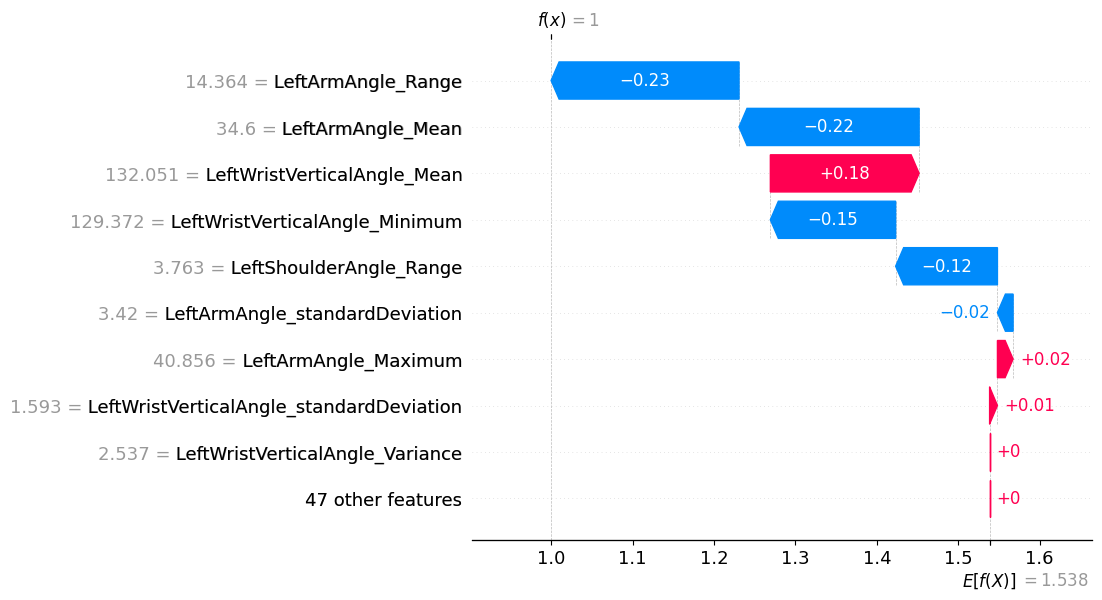

¡Buen trabajo con ese LeftArmAngle_Range
Repetición 6: incorrecta


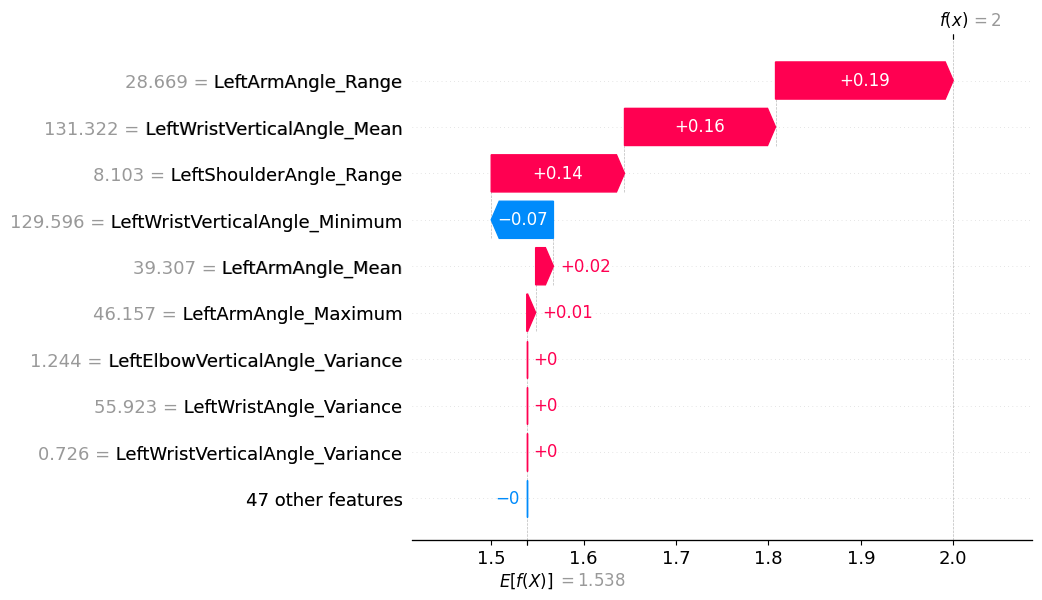

Mejora LeftArmAngle_Range
Repetición 7: correcta


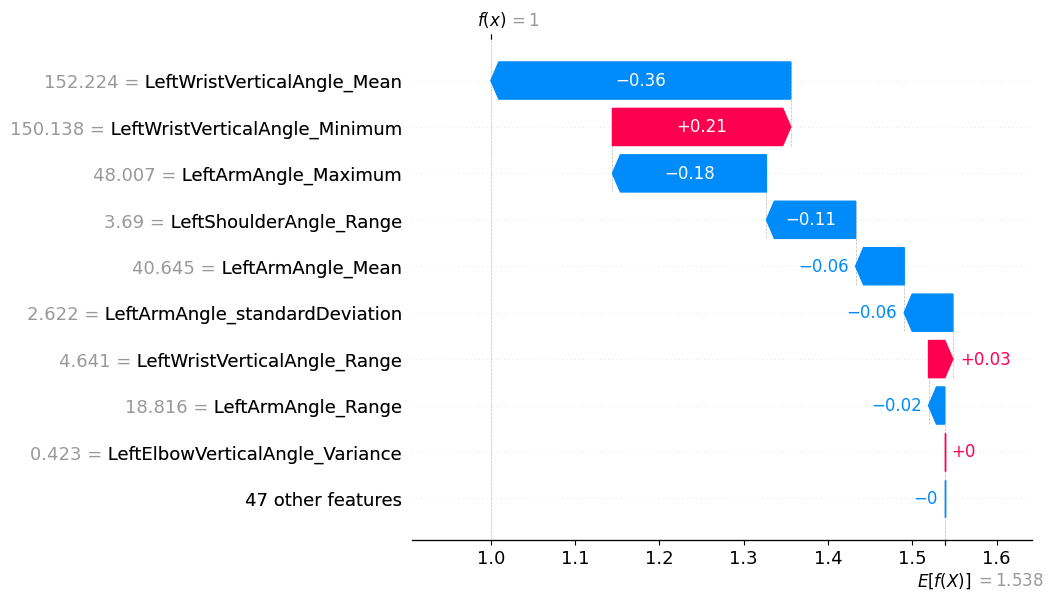

¡Buen trabajo con ese LeftArmAngle_Range
Repetición 8: correcta


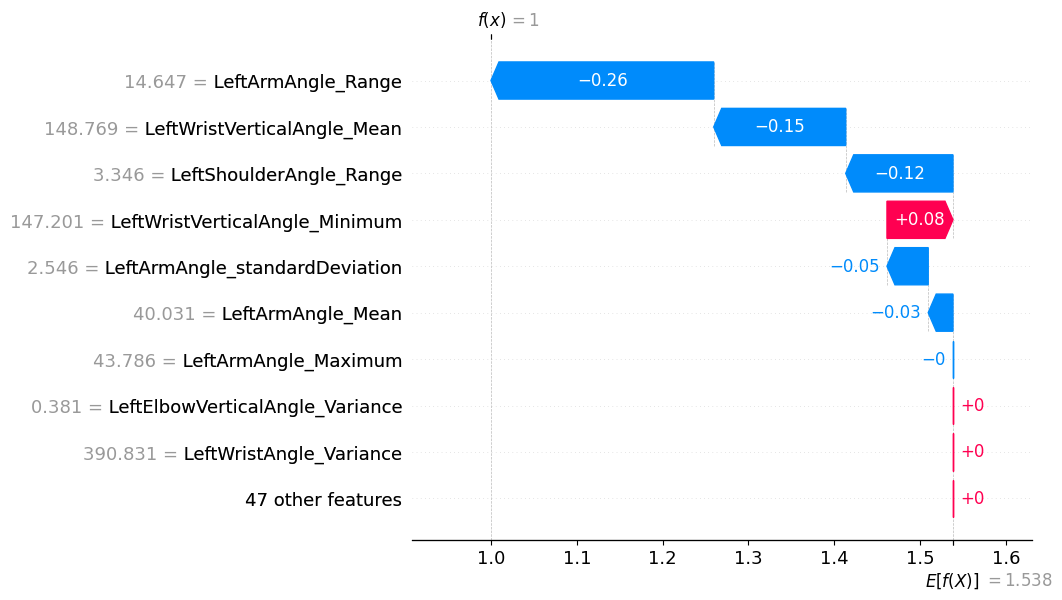

¡Buen trabajo con ese LeftArmAngle_Range
Repetición 9: incorrecta


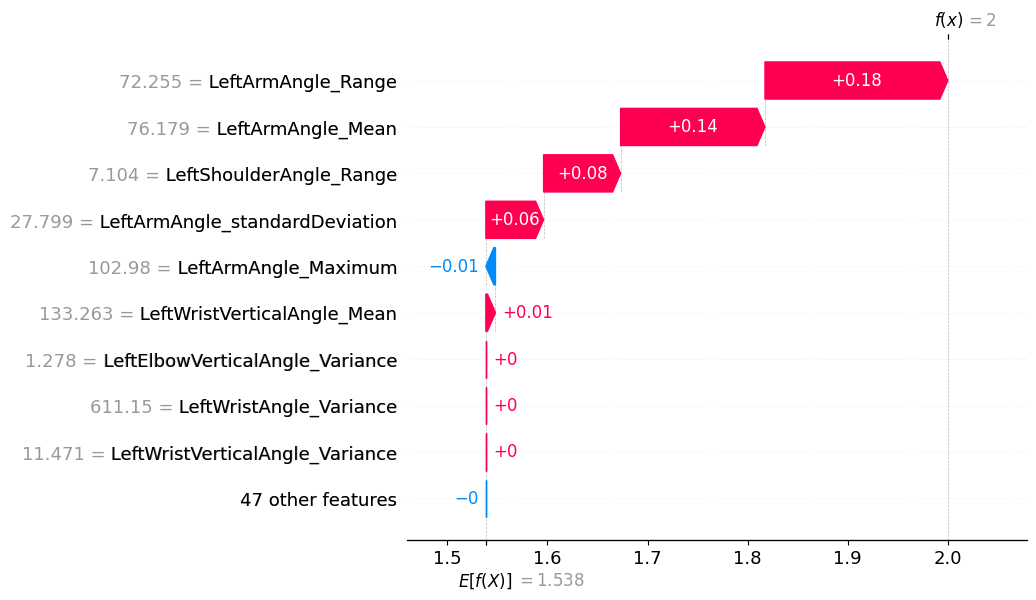

Mejora LeftArmAngle_Range
Repetición 10: incorrecta


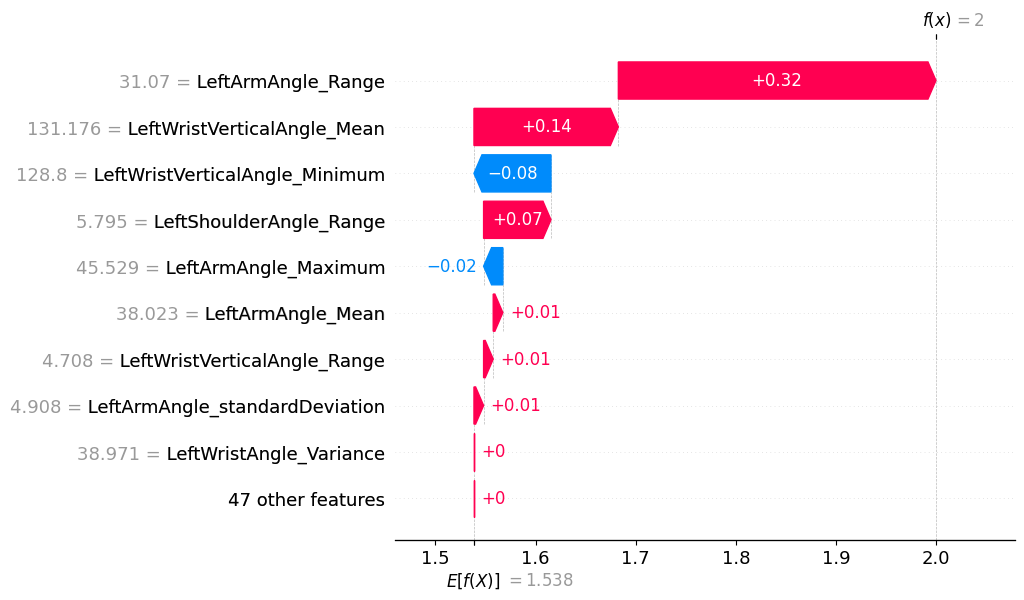

Mejora LeftArmAngle_Range
Repetición 11: incorrecta


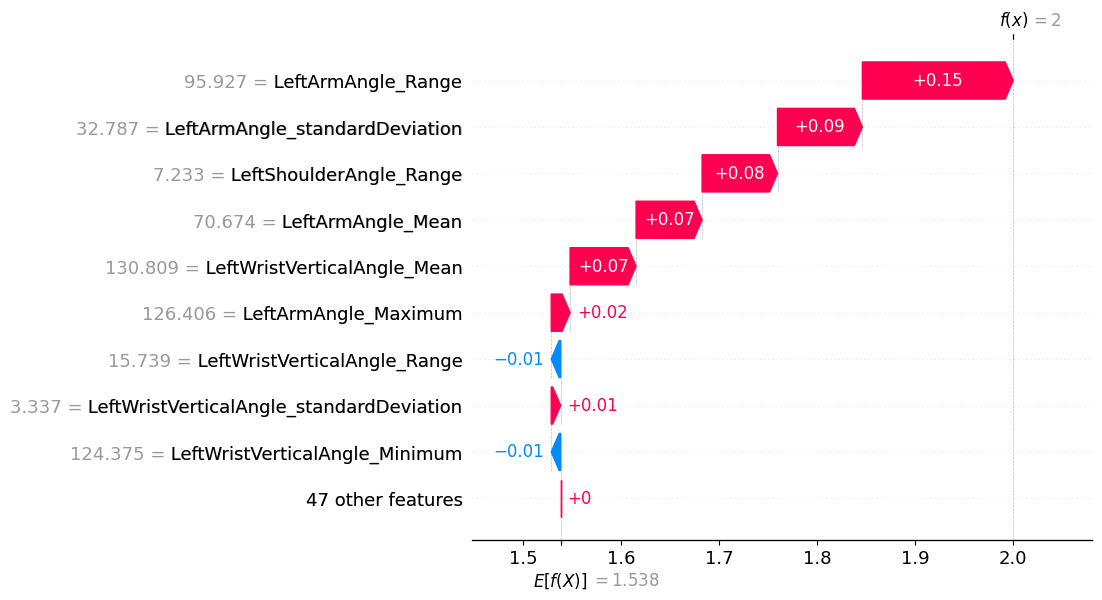

Mejora LeftArmAngle_Range
Repetición 12: incorrecta


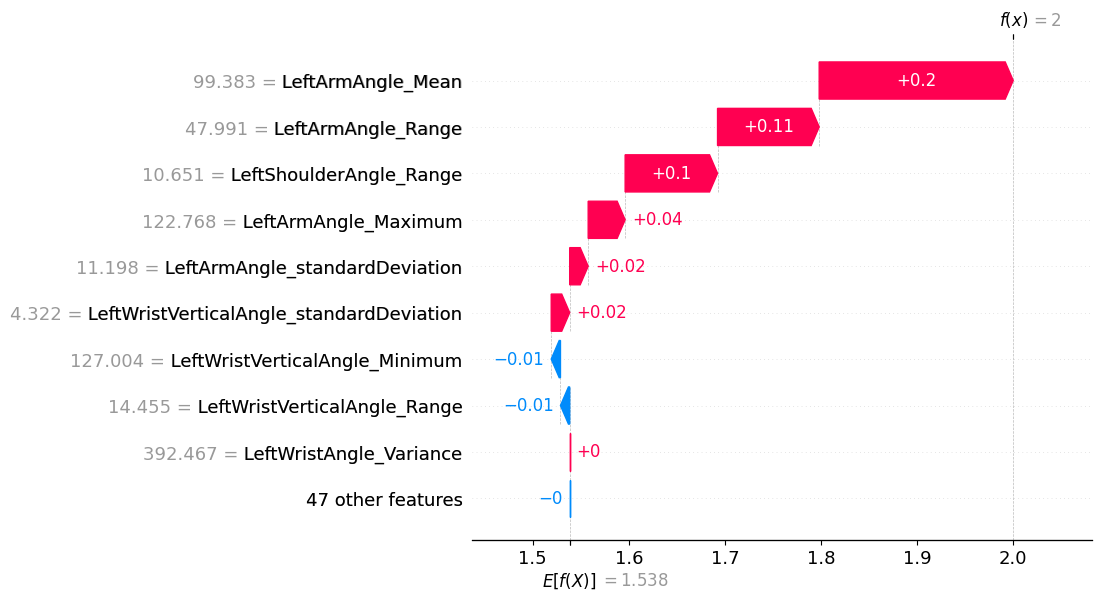

Mejora LeftArmAngle_Range
Repetición 13: incorrecta


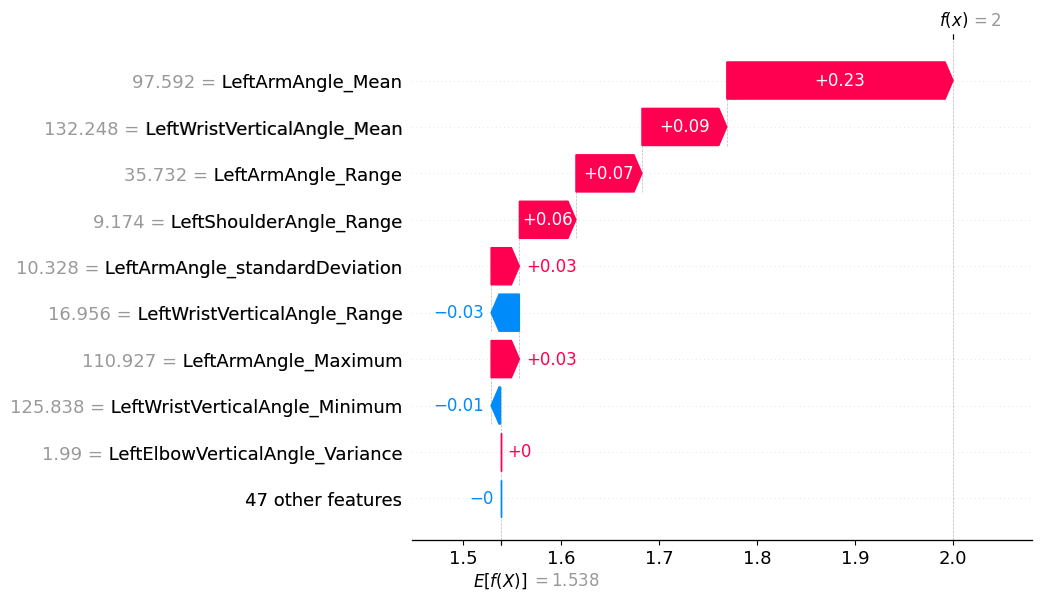

Mejora LeftArmAngle_Range


In [18]:
# SHAP
explainer = shap.Explainer(best_pipeline.predict, df_stats)
shap_values = explainer(df_stats)

correct_labels = best_pipeline.predict(df_stats)

for i, correct_label in enumerate(correct_labels):
    correct_name = correct_mapping.get(correct_label, 'Error en la predición')
    repetition_number = df_stats['RepetitionNumber'].iloc[i]
    
    if correct_label in [1, 2]:
        print(f'Repetición {repetition_number}: {correct_name}')
        
        # Get SHAP values for this prediction
        shap_values_for_prediction = shap_values[i]
        feature_importance = np.abs(shap_values.values).mean(axis=0)
        importance_df = pd.DataFrame({'feature': expected_columns, 'importance': feature_importance})
        importance_df = importance_df.sort_values('importance', ascending=False)

        #shap.plots.bar(shap_values_for_prediction) # para entender las características mas importantes
        # the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
        shap.plots.waterfall(shap_values_for_prediction)
        if correct_label == 1:
            print('¡Buen trabajo con ese ' + importance_df.iloc[0]['feature'])
        else:
            print('Mejora ' + importance_df.iloc[0]['feature'])
       
    else:
        print("Error en la predición")

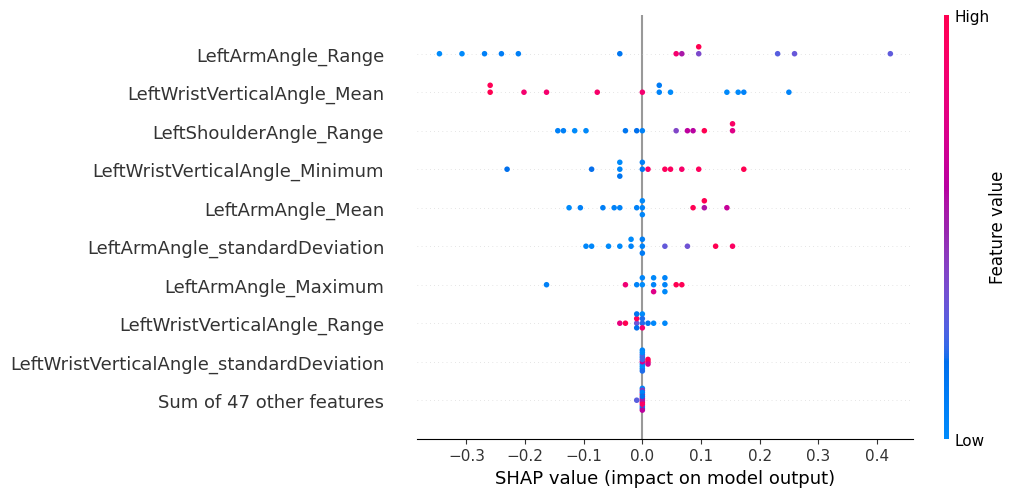

In [ ]:
# the beeswarm plot displays SHAP values for each feature across all examples,
# with colors indicating how the SHAP values correlate with feature values
shap.plots.beeswarm(shap_values)